In [1]:
import torch
import numpy as np

### Load Dataset

In [2]:
from torch.utils.data import DataLoader

In [3]:
data = np.load('./dataset/data64.npy')

In [4]:
data.shape

(3376, 3, 64, 64)

In [5]:
# normalize to [-1, 1] as said in DCGAN paper
normalizer = lambda p: (p/255)*(1 - (-1)) - 1
vfunc = np.vectorize(normalizer)
data_n = vfunc(data)

In [6]:
dataset = DataLoader(data_n,batch_size = 64,shuffle=True)

## WGAN

In [7]:
import torch.nn as nn

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, init_output = 64):
        super(Discriminator,self).__init__()
        params = {'kernel_size': 5, 'stride': 2, 'padding': 2}
        self.init_output = init_output
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = init_output, **params),
            nn.BatchNorm2d(num_features = init_output),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = init_output, out_channels = init_output*2, **params),
            nn.BatchNorm2d(num_features = init_output*2),
            nn.LeakyReLU(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = init_output*2, out_channels = init_output*4, **params),
            nn.BatchNorm2d(num_features = init_output*4),
            nn.LeakyReLU(0.2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = init_output*4, out_channels = init_output*8, **params),
            nn.BatchNorm2d(num_features = init_output*8),
            nn.LeakyReLU(0.2)
        )
        self.output = nn.Linear(init_output*8*16,1)
        self.layers = [self.layer1,self.layer2,self.layer3,self.layer4]
        
    def forward(self,X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(-1,self.init_output*8*16)
        X = self.output(X)
        return X

In [9]:
class Generator(nn.Module):
    
    def __init__(self,total_out = 4*4*1024):
        super(Generator,self).__init__()
        
        # don't forget to reshape after this
        self.layer1 = nn.Sequential(
            nn.Linear(100,out_features = total_out),
            nn.BatchNorm1d(num_features = total_out)
        )
        p = lambda first: {'kernel_size': 5, 'stride': 2-first, 'padding': 2*(1-first), 'output_padding': 1-first}
        
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 1024,out_channels = 512,**(p(1))),
            nn.BatchNorm2d(num_features = 512),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 512,out_channels = 256,**(p(0))),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU()
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256,out_channels = 128,**(p(0))),
            nn.BatchNorm2d(num_features = 128),
            nn.ReLU()
        )
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 128,out_channels = 3,**(p(0))),
            nn.Tanh()
        )
        self.upconv = [self.up1,self.up2,self.up3,self.up4]
    
    def forward(self,bs):
        # sample from normal distribution
        Z = torch.randn((bs,100)).cuda()
        X = self.layer1(Z)
        # reshape into 4D-tensor of 1 3d tensor
        X = X.view(bs,1024,4,4)
        for up in self.upconv:
            X = up(X)
        return X

In [16]:
n_critics = 5
critic = Discriminator().cuda()

In [17]:
G = Generator().cuda()

## Training

In [12]:
import torchvision
from torchvision import transforms

In [13]:
flip = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip()
])

In [19]:
optimizerD = torch.optim.Adam(critic.parameters(),lr = 0.00005, betas = (0.5,0.999))
optimizerG = torch.optim.Adam(G.parameters(),lr = 0.00005, betas = (0.5,0.999))
EPOCHS = 100
for e in range(EPOCHS):
    G.train()
    d_losses = []
    g_losses = []
    for batch in dataset:
        # critics
        tmp = []
        for _ in range(n_critics):
            critic.zero_grad()
            G.zero_grad()
            true_mean = critic(batch.float().cuda()).mean()
            gen_mean = critic(G(64)).mean()
            critic_loss = gen_mean - true_mean # earth mover's
            critic_loss.backward()
            optimizerD.step()
            # clip weights
            for p in critic.parameters():
                p.data.clamp_(-0.01, 0.01)
            tmp.append(critic_loss.item())
        d_losses.append(np.mean(tmp))
        
        # Generator Loss
        G.zero_grad()
        critic.zero_grad()
        gen_loss = -1 * critic(G(64)).mean()
        g_losses.append(gen_loss.item())
        gen_loss.backward()
        optimizerG.step()
    print("Epoch %d: Discriminator Loss: %0.3f \t Generator Loss: %.3f" % (e,np.mean(d_losses),np.mean(g_losses)))
    if e%5 == 0:
        G.eval()
        ex = G(12).cpu().detach().numpy()
        out = np.moveaxis(ex,1,3)
    #     imgs = vf(out)
    #     imgs = np.clip(img,0,255).astype('uint8')
        np.save('./results/wgan_anime_epoch_' + str(e),out)
#     break
    

Epoch 0: Discriminator Loss: -1.266 	 Generator Loss: 0.642
Epoch 1: Discriminator Loss: -1.239 	 Generator Loss: 0.667
Epoch 2: Discriminator Loss: -1.304 	 Generator Loss: 0.690
Epoch 3: Discriminator Loss: -1.356 	 Generator Loss: 0.704
Epoch 4: Discriminator Loss: -1.288 	 Generator Loss: 0.693
Epoch 5: Discriminator Loss: -1.187 	 Generator Loss: 0.673
Epoch 6: Discriminator Loss: -1.148 	 Generator Loss: 0.656
Epoch 7: Discriminator Loss: -1.097 	 Generator Loss: 0.647
Epoch 8: Discriminator Loss: -1.000 	 Generator Loss: 0.626
Epoch 9: Discriminator Loss: -1.076 	 Generator Loss: 0.630
Epoch 10: Discriminator Loss: -1.079 	 Generator Loss: 0.631
Epoch 11: Discriminator Loss: -1.082 	 Generator Loss: 0.608
Epoch 12: Discriminator Loss: -1.077 	 Generator Loss: 0.631
Epoch 13: Discriminator Loss: -1.042 	 Generator Loss: 0.611
Epoch 14: Discriminator Loss: -1.081 	 Generator Loss: 0.615
Epoch 15: Discriminator Loss: -1.051 	 Generator Loss: 0.587
Epoch 16: Discriminator Loss: -1.0

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
G.eval()

Generator(
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=True)
    (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up4): Sequential(
    (0): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1,

In [23]:
out = G(1)[0].cpu().detach().numpy()

In [24]:
out = np.moveaxis(out,0,2)

In [25]:
denormalizer = lambda p: (p+1)*255/2

In [26]:
vf = np.vectorize(denormalizer)

In [27]:
img = vf(out)

In [28]:
img = np.clip(img,0,255).astype('uint8')

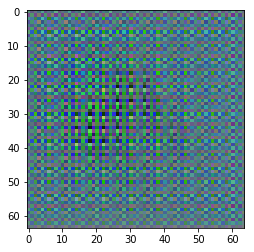

In [29]:
plt.imshow(img)

In [117]:
imgs.shape

(64, 64, 3)

In [115]:
ex.shape

(12, 3, 64, 64)